**Technocolabs Softwares Internship mini project: Bank Depts**

Problem Statement:
After a debt has been legally declared "uncollectable" by a bank, the account is considered to be "charged-off." But that doesn't mean the bank simply walks away from the debt. They still want to collect some of the money they are owed. In this project, you will look at a situation where a bank assigned delinquent customers to different recovery strategies based on the expected amount the bank believed it would recover from the customer. The goal for the data scientist is to determine in this non-random assignment whether the incremental amount the bank earns exceeded the additional cost of assigning customers to a higher recovery strategy.
Threshold assignments like this also one occur in medicine (above a certain temperature you get medicine), education (above a certain test score students get admitted to a special class), other areas of finance (above a certain wealth customers get different levels of service), and public sector (below a certain income someone is eligible for housing benefits). Regression discontinuity is an intuitive and useful analysis method in any situation of a threshold assignment.

Importing Libraries

In [1]:
import numpy as np
import pandas as pd

# Data Visualisation Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Train Test Split
from sklearn.model_selection import train_test_split

# Metrics
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score as R2


# ML Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor


Now that we loaded the libraries that we are going to need during the imple;entation of this project, let's load our Data and take a look at it

In [2]:
#load the data
from google.colab import files

uploaded = files.upload()

bank_data = pd.read_csv(next(iter(uploaded.keys())))


Saving bank_data.csv to bank_data.csv


In [3]:
#first look at the data

bank_data.head(10)

,id,expected_recovery_amount,actual_recovery_amount,recovery_strategy,age,sex
0,2030,194,263.540,Level 0 Recovery,19,Male
1,1150,486,416.090,Level 0 Recovery,25,Female
2,380,527,429.350,Level 0 Recovery,27,Male
3,1838,536,296.990,Level 0 Recovery,25,Male
4,1995,541,346.385,Level 0 Recovery,34,Male
5,731,548,520.710,Level 0 Recovery,35,Male
6,221,549,221.585,Level 0 Recovery,33,Male
7,1932,560,373.720,Level 0 Recovery,19,Female
8,1828,562,201.865,Level 0 Recovery,22,Female
9,2001,565,504.885,Level 0 Recovery,27,Male


In [4]:
# The shape of ou Data set
bank_data.shape

(1882, 6)

## 1.Regression Discontinuity: Banking recovery\
Key variables :

*   expected recovery amount
*   recovery strategy level
*   actual recovery amount
*   age
*   sexe

Levels and threshold:

*   Level 0: Expected recovery amounts >  0$ & <= 1000$
*   Level 1: Expected recovery amounts >  1000$ & <= 2000$
*   The threshold of $1000 separates Level 0 from Level

let's see how many customers in every recovery level and the thereshold of 1000$


In [5]:
bank_data['recovery_strategy'].value_counts()

Level 1 Recovery    670
Level 3 Recovery    368
Level 2 Recovery    333
Level 4 Recovery    264
Level 0 Recovery    247
Name: recovery_strategy, dtype: int64

<Axes: >

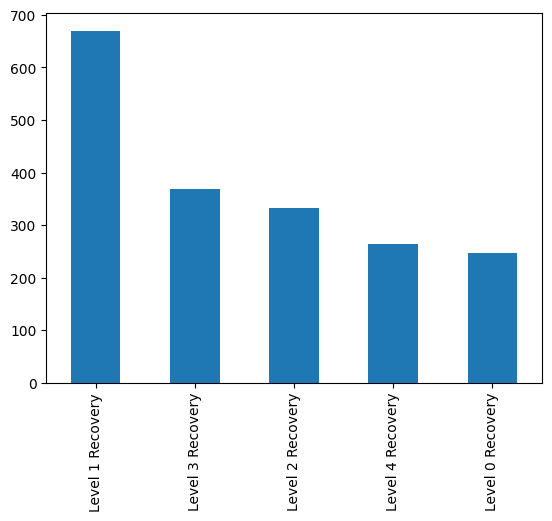

In [6]:
bank_data['recovery_strategy'].value_counts().plot(kind='bar')


Now Let's select a sample of customers that fall within a narrow range around the threshold (betweeen 900$ & 1100$)

Number of customers in the sample: 183


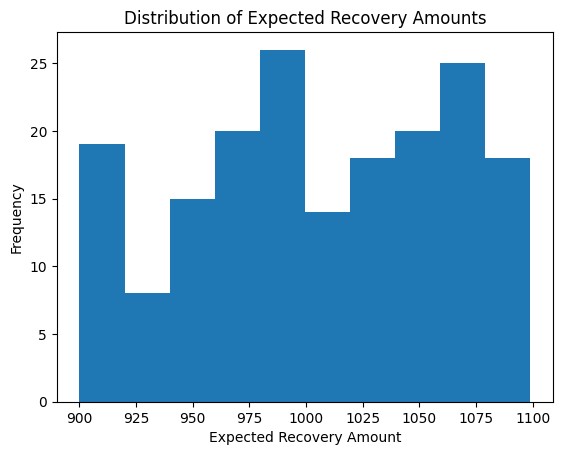

In [39]:
sample = bank_data[(bank_data['expected_recovery_amount'] >= 900) & (bank_data['expected_recovery_amount'] < 1100)]

# Print the number of customers in the sample
print("Number of customers in the sample:", len(sample))

# you can plot the distribution of expected recovery amounts in the sample

plt.hist(sample['expected_recovery_amount'], bins=10)
plt.xlabel('Expected Recovery Amount')
plt.ylabel('Frequency')
plt.title('Distribution of Expected Recovery Amounts')
plt.show()

In [8]:
sample.head()

,id,expected_recovery_amount,actual_recovery_amount,recovery_strategy,age,sex
158,520,900,504.790,Level 0 Recovery,34,Male
159,1036,900,539.535,Level 0 Recovery,34,Female
160,1383,900,554.745,Level 0 Recovery,24,Male
161,998,901,887.005,Level 0 Recovery,32,Male
162,1351,903,667.035,Level 0 Recovery,28,Male


let's Create scatter plots to examine the relationship between the expected recovery amount (X-axis) and the actual recovery amount (Y-axis) for the selected sample.

let's take a look on the relation between the expected recovery amount and the actual recovery amount


<function matplotlib.pyplot.show(close=None, block=None)>

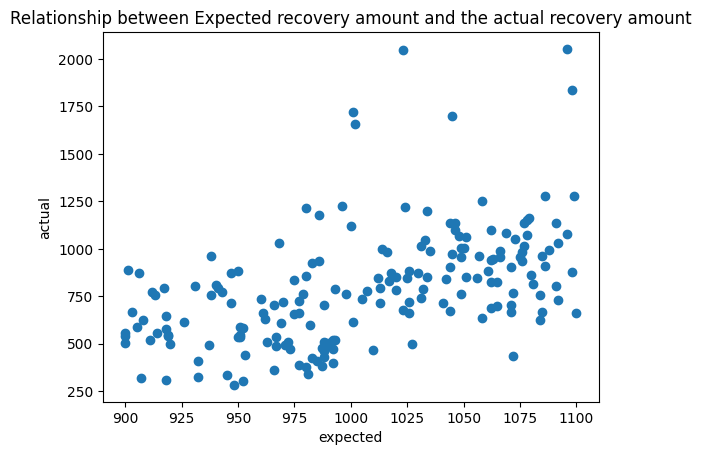

In [9]:
print("let's take a look on the relation between the expected recovery amount and the actual recovery amount")

plt.scatter(sample["expected_recovery_amount"], sample["actual_recovery_amount"])
plt.xlabel("expected")
plt.ylabel("actual")
plt.title("Relationship between Expected recovery amount and the actual recovery amount")
plt.show

Here, we can see that there is a big difference between the expected recovery amount and the actual recovery amount for some customers(expected recovery amount between 900 and 1100)

Data Cleaning

In [10]:
missings_values= bank_data.isnull().sum()
missings_values

id                          0
expected_recovery_amount    0
actual_recovery_amount      0
recovery_strategy           0
age                         0
sex                         0
dtype: int64

In [11]:
bank_data.duplicated().sum()

0

In [12]:
strategies=bank_data['recovery_strategy'].unique()
strategies

array(['Level 0 Recovery', 'Level 1 Recovery', 'Level 2 Recovery',
       'Level 3 Recovery', 'Level 4 Recovery'], dtype=object)

## 2. Graphical exploratory data analysis

The bank has implemented different recovery strategies at different thresholds (\$1000, \$2000, \$3000 and \$5000) where the greater the Expected Recovery Amount, the more effort the bank puts into contacting the customer. Zeroing in on the first transition (between Level 0 and Level 1) means we are focused on the population with Expected Recovery Amounts between \$0 and \$2000 where the transition between Levels occurred at \$1000. We know that the customers in Level 1 (expected recovery amounts between \$1001 and \$2000) received more attention from the bank and, by definition, they had higher Expected Recovery Amounts than the customers in Level 0 (between \$1 and \$1000).

Here's a quick summary of the Levels and thresholds again:

Level 0: Expected recovery amounts >\$0 and <=\$1000

Level 1: Expected recovery amounts >\$1000 and <=\$2000

The threshold of \$1000 separates Level 0 from Level 1

A key question is whether there are other factors besides Expected Recovery Amount that also varied systematically across the \$1000 threshold. For example, does the customer age show a jump (discontinuity) at the \$1000 threshold or does that age vary smoothly? We can examine this by first making a scatter plot of the age as a function of Expected Recovery Amount for a small window of Expected Recovery Amount, \$0 to \$2000. This range covers Levels 0 and 1.

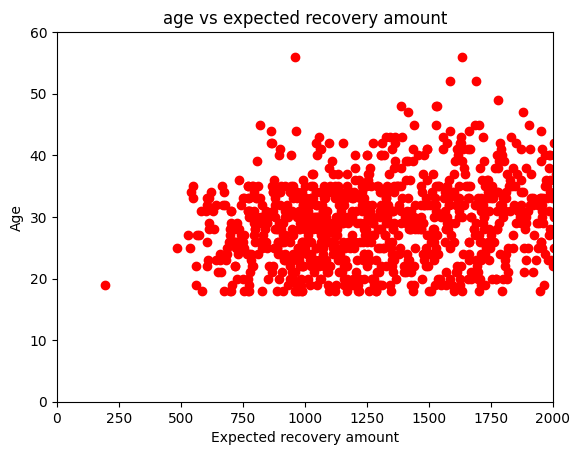

In [34]:
#let's do a scatter plot of age as a fucntion of the expected recovery amount

plt.scatter(bank_data['expected_recovery_amount'], bank_data['age'], c='r')
plt.xlim(0, 2000)
plt.ylim(0, 60)
plt.xlabel('Expected recovery amount')
plt.ylabel('Age')
plt.title('age vs expected recovery amount')
plt.show()

## 3.Statistical test: age vs. expected recovery amount

We want to convince ourselves that variables such as age and sex are similar above and below the \$1000 Expected Recovery Amount threshold. This is important because we want to be able to conclude that differences in the actual recovery amount are due to the higher Recovery Strategy and not due to some other difference like age or sex.

The scatter plot of age versus Expected Recovery Amount did not show an obvious jump around \$1000. We will be more confident in our conclusions if we do statistical analysis examining the average age of the customers just above and just below the threshold. We can start by exploring the range from \$900 to \$1100.

For determining if there is a difference in the ages just above and just below the threshold, we will use the Kruskal-Wallis test which is a statistical test that makes no distributional assumptions.

In [14]:
sample.head()

,id,expected_recovery_amount,actual_recovery_amount,recovery_strategy,age,sex
158,520,900,504.790,Level 0 Recovery,34,Male
159,1036,900,539.535,Level 0 Recovery,34,Female
160,1383,900,554.745,Level 0 Recovery,24,Male
161,998,901,887.005,Level 0 Recovery,32,Male
162,1351,903,667.035,Level 0 Recovery,28,Male


In [15]:
# average age above the threshold of 1000$
avg_age_above_threshold= sample[sample['expected_recovery_amount']<=1000]['age'].mean()

# average age bellow the thresholod of 1000$
avg_age_bellow_threshold = sample[sample['expected_recovery_amount']> 1000]['age'].mean()

print('the average age above the threshold is :', avg_age_above_threshold)
print("the average age bellow the threshold is :", avg_age_bellow_threshold)

the average age above the threshold is : 27.224719101123597
the average age bellow the threshold is : 28.68421052631579


In [43]:
# Import stats module
from scipy import stats

# Compute average age just below and above the threshold (2)
by_recovery_strategy = sample.groupby(['recovery_strategy'])
by_recovery_strategy['age'].describe().unstack()

# Perform Kruskal-Wallis test
Level_0_age = sample.loc[bank_data['recovery_strategy']=="Level 0 Recovery"]['age']
Level_1_age = sample.loc[bank_data['recovery_strategy']=="Level 1 Recovery"]['age']
stats.kruskal(Level_0_age, Level_1_age)

KruskalResult(statistic=3.4572342749517513, pvalue=0.06297556896097407)

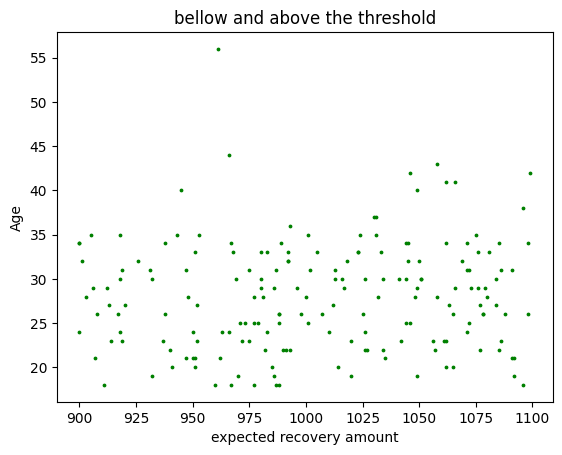

In [46]:
#scatter plot of the above and bellow of the threshold

plt.scatter(sample['expected_recovery_amount'],sample['age'], c='g', s=3)
plt.xlabel('expected recovery amount')
plt.ylabel('Age')
plt.title('bellow and above the threshold')
plt.show()

## 4.Statistical test: sex vs. expected recovery amount

We were able to convince ourselves that there is no major jump in the average customer age just above and just below the \$1000 threshold by doing a statistical test as well as exploring it graphically with a scatter plot.

We want to also test that the percentage of customers that are male does not jump as well across the \$1000 threshold. We can start by exploring the range of \$900 to \$1100 and later adjust this range.

We can examine this question statistically by developing cross-tabs as well as doing chi-square tests of the percentage of customers that are male vs. female.

In [18]:
male_count = sample['sex'].value_counts()['Male']
female_count = sample['sex'].value_counts()['Female']
total_count = sample['sex'].count()

# Print the result
print("Number of Male:", male_count)
print("Number of Female:", female_count)
print("Total of value i Sex Columns:", total_count)

Number of Male: 112
Number of Female: 72
Total of value i Sex Columns: 184


In [19]:
#percentage of Male
perce_male = round((male_count/total_count)*100, 3)
perce_female = round((female_count/total_count)*100, 3)

print("The percentage of Male in our sample is :", perce_male,"%")
print("The precentage of Females in our sample is :", perce_female,"%")

The percentage of Male in our sample is : 60.87 %
The precentage of Females in our sample is : 39.13 %


In [51]:
# Number of customers in each category
crosstab = pd.crosstab(bank_data.loc[(bank_data['expected_recovery_amount']<1100) &
                              (bank_data['expected_recovery_amount']>=900)]['recovery_strategy'],
                       bank_data['sex'])
print(crosstab)

# Chi-square test
chi2_stat, p_val, dof, ex = stats.chi2_contingency(crosstab)
print(p_val)

sex                Female  Male
recovery_strategy              
Level 0 Recovery       32    57
Level 1 Recovery       39    55
0.5377947810444592


Text(0, 0.5, 'Expected Recovery Amount')

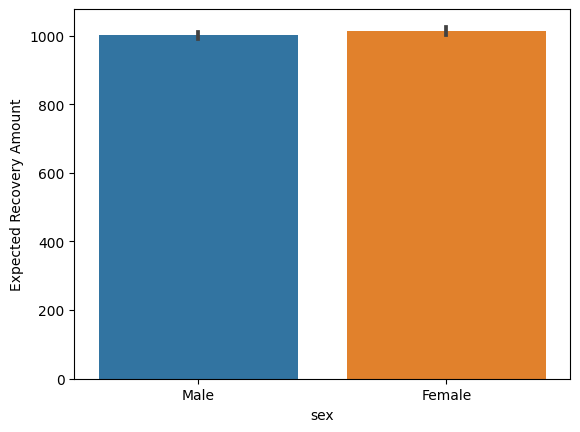

In [20]:
#let's plot The expected recovery amount as a function of sex

sns.barplot(x=sample['sex'], y=sample['expected_recovery_amount'])
plt.ylabel("Expected Recovery Amount")

## 5. Exploratory graphical analysis: recovery amount

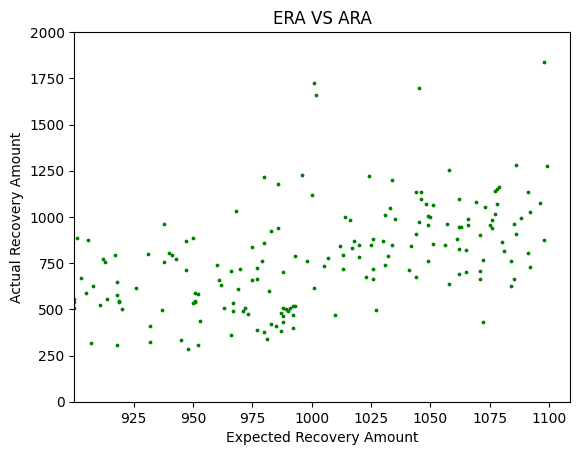

In [53]:
#scatter plot of Expected Recovery Amount VS Actual Recovery Amount
plt.scatter(sample['expected_recovery_amount'], sample['actual_recovery_amount'], c='g', s=3)
plt.ylabel("Actual Recovery Amount")
plt.xlabel("Expected Recovery Amount")
plt.ylim(0, 2000)
plt.xlim(900.1100)
plt.title("ERA VS ARA")
plt.show()

## 6. Statistical analysis: recovery amount

<p>Just as we did with age, we can perform statistical tests to see if the actual recovery amount has a discontinuity above the \$1000 threshold. We are going to do this for two different windows of the expected recovery amount \$900 to \$1100 and for a narrow range of \$950 to \$1050 to see if our results are consistent.</p>
<p>Again, the statistical test we will use is the Kruskal-Wallis test, a test that makes no assumptions about the distribution of the actual recovery amount.</p>
<p>We will first compute the average actual recovery amount for those customers just below and just above the threshold using a range from \$900 to \$1100.  Then we will perform a Kruskal-Wallis test to see if the actual recovery amounts are different just above and just below the threshold.  Once we do that, we will repeat these steps for a smaller window of \$950 to \$1050.</p>

In [54]:
# let's create a subset of range 950$ and 1050$

sample_2= bank_data[(bank_data['expected_recovery_amount'] >= 950) & (bank_data['expected_recovery_amount'] < 1050)]

In [55]:
sample_2.head()

,id,expected_recovery_amount,actual_recovery_amount,recovery_strategy,age,sex
192,1619,950,883.790,Level 0 Recovery,21,Female
193,1898,950,534.910,Level 0 Recovery,24,Male
194,212,951,543.780,Level 0 Recovery,33,Female
195,1329,951,537.985,Level 0 Recovery,20,Male
196,1751,951,589.435,Level 0 Recovery,21,Male


In [56]:
# Compute average actual recovery amount just below and above the threshold
by_recovery_strategy['actual_recovery_amount'].describe().unstack()

# Perform Kruskal-Wallis test
Level_0_actual = sample.loc[bank_data['recovery_strategy']=='Level 0 Recovery']['actual_recovery_amount']
Level_1_actual = sample.loc[bank_data['recovery_strategy']=='Level 1 Recovery']['actual_recovery_amount']
print(stats.kruskal(Level_0_actual, Level_1_actual))

# Repeat for a smaller range of $950 to $1050

Level_0_actual = sample_2.loc[bank_data['recovery_strategy']=='Level 0 Recovery']['actual_recovery_amount']
Level_1_actual = sample_2.loc[bank_data['recovery_strategy']=='Level 1 Recovery']['actual_recovery_amount']
stats.kruskal(Level_0_actual, Level_1_actual)

KruskalResult(statistic=65.37966302528878, pvalue=6.177308752803109e-16)


KruskalResult(statistic=30.246000000000038, pvalue=3.80575314300276e-08)

## 7. Regression modeling: no threshold

We now want to take a regression-based approach to estimate the impact of the program at the \$1000 threshold using the data that is just above and just below the threshold. In order to do that, we will build two models. The first model does not have a threshold while the second model will include a threshold.

The first model predicts the actual recovery amount (outcome or dependent variable) as a function of the expected recovery amount (input or independent variable). We expect that there will be a strong positive relationship between these two variables.

We will examine the adjusted R-squared to see the percent of variance that is explained by the model. In this model, we are not trying to represent the threshold but simply trying to see how the variable used for assigning the customers (expected recovery amount) relates to the outcome variable (actual recovery amount).

In [57]:
# Import statsmodels
import statsmodels.api as sm

# Define X and y
X = sample['expected_recovery_amount']
y = sample['actual_recovery_amount']
X = sm.add_constant(X)

# Build linear regression model
model = sm.OLS(y, X).fit()
predictions = model.predict(X)

# Print out the model summary statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     actual_recovery_amount   R-squared:                       0.261
Model:                                OLS   Adj. R-squared:                  0.256
Method:                     Least Squares   F-statistic:                     63.78
Date:                    Tue, 25 Jul 2023   Prob (F-statistic):           1.56e-13
Time:                            14:18:53   Log-Likelihood:                -1278.9
No. Observations:                     183   AIC:                             2562.
Df Residuals:                         181   BIC:                             2568.
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                    -1978.7597    347.741     -5.690      0.000   -2664.907   -1292.612
expected_recovery_amount     2.7577      0.345      7.986      0.000       2.076       3.439
==============================================================================
Omnibus:                       64.493   Durbin-Watson:                   1.777
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              185.818
Skew:                           1.463   Prob(JB):                     4.47e-41
Kurtosis:                       6.977   Cond. No.                     1.80e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.8e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## 8. Regression modeling: adding true threshold

From the first model, we see that the regression coefficient is statistically significant for the expected recovery amount and the adjusted R-squared value was about 0.26. As we saw from the graph, on average the actual recovery amount increases as the expected recovery amount increases. We could add polynomial terms of expected recovery amount (such as the squared value of expected recovery amount) to the model but, for the purposes of this practice, let's stick with using just the linear term.

The second model adds an indicator of the true threshold to the model. If there was no impact of the higher recovery strategy on the actual recovery amount, then we would expect that the relationship between the expected recovery amount and the actual recovery amount would be continuous.

In this case, we know the true threshold is at \$1000.

We will create an indicator variable (either a 0 or a 1) that represents whether or not the expected recovery amount was greater than \$1000. When we add the true threshold to the model, the regression coefficient for the true threshold represents the additional amount recovered due to the higher recovery strategy. That is to say, the regression coefficient for the true threshold measures the size of the discontinuity for customers just above and just below the threshold.

If the higher recovery strategy did help recovery more money, then the regression coefficient of the true threshold will be greater than zero. If the higher recovery strategy did not help recover more money than the regression coefficient will not be statistically significant.

In [68]:
# Create indicator (0 or 1) for expected recovery amount >= $1000
bank_data['indicator_1000'] = np.where(bank_data['expected_recovery_amount']<1000, 0, 1)
sample = bank_data.loc[(bank_data['expected_recovery_amount']<1100) & (bank_data['expected_recovery_amount']>=900)]

# Define X and y
X = sample['expected_recovery_amount']
y = sample['actual_recovery_amount']
X = sm.add_constant(X)

# Build linear regression model
model = sm.OLS(y,X).fit()

# Print the model summary
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     actual_recovery_amount   R-squared:                       0.261
Model:                                OLS   Adj. R-squared:                  0.256
Method:                     Least Squares   F-statistic:                     63.78
Date:                    Tue, 25 Jul 2023   Prob (F-statistic):           1.56e-13
Time:                            14:37:11   Log-Likelihood:                -1278.9
No. Observations:                     183   AIC:                             2562.
Df Residuals:                         181   BIC:                             2568.
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                    -1978.7597    347.741     -5.690      0.000   -2664.907   -1292.612
expected_recovery_amount     2.7577      0.345      7.986      0.000       2.076       3.439
==============================================================================
Omnibus:                       64.493   Durbin-Watson:                   1.777
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              185.818
Skew:                           1.463   Prob(JB):                     4.47e-41
Kurtosis:                       6.977   Cond. No.                     1.80e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.8e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## 9. Regression modeling: adjusting the window

<p>The regression coefficient for the true threshold was statistically significant with an estimated impact of around \$278 and a 95 percent confidence interval of \$132 to \$424.  This is much larger than the incremental cost of running the higher recovery strategy which was \$50 per customer. At this point, we are feeling reasonably confident that the higher recovery strategy is worth the additional costs of the program for customers just above and just below the threshold.  </p>
<p>Before showing this to our managers, we want to convince ourselves that this result wasn't due just to us choosing a window of \$900 to \$1100 for the expected recovery amount. If the higher recovery strategy really had an impact of an extra few hundred dollars, then we should see a similar regression coefficient if we choose a slightly bigger or a slightly smaller window for the expected recovery amount.  Let's repeat this analysis for the window of expected recovery amount from \$950 to \$1050 to see if we get similar results.</p>
<p>The answer? Whether we use a wide window (\$900 to \$1100) or a narrower window (\$950 to \$1050), the incremental recovery amount at the higher recovery strategy is much greater than the \$50 per customer it costs for the higher recovery strategy.  So we can say that the higher recovery strategy is worth the extra \$50 per customer that the bank is spending.</p>

In [67]:
# Redefine sample_2 so the indicator variable is included
sample_2 = bank_data.loc[(bank_data['expected_recovery_amount']<1050) & (bank_data['expected_recovery_amount']>=950)]

# Define X and y
X = sample_2[['expected_recovery_amount','indicator_1000']]
y = sample_2['actual_recovery_amount']
X = sm.add_constant(X)

# Build linear regression model
model = sm.OLS(y,X).fit()

# Print the model summary
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     actual_recovery_amount   R-squared:                       0.283
Model:                                OLS   Adj. R-squared:                  0.269
Method:                     Least Squares   F-statistic:                     18.99
Date:                    Tue, 25 Jul 2023   Prob (F-statistic):           1.12e-07
Time:                            14:36:45   Log-Likelihood:                -692.92
No. Observations:                      99   AIC:                             1392.
Df Residuals:                          96   BIC:                             1400.
Df Model:                               2                                         
Covariance Type:                nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                     -279.5243   1840.707     -0.152      0.880   -3933.298    3374.250
expected_recovery_amount     0.9189      1.886      0.487      0.627      -2.825       4.663
indicator_1000             286.5337    111.352      2.573      0.012      65.502     507.566
==============================================================================
Omnibus:                       39.302   Durbin-Watson:                   1.955
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               82.258
Skew:                           1.564   Prob(JB):                     1.37e-18
Kurtosis:                       6.186   Cond. No.                     6.81e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.81e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""